In [1]:
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import string
import h5py

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, CuDNNLSTM, CuDNNGRU, Conv1D, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split, KFold


import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from capstone_utils import *

# Inline plotting
%matplotlib inline
pd.set_option('display.width', 200)
pd.set_option('max_colwidth', 2000)

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Config
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

MAX_SEQUENCE_LENGTH = 300
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 300

In [3]:
train, test, corpus = load_data('../data', clean=False, lower_stop=False)

Loading questions...
Done loading train - Loading test
Done loading test


In [4]:
word2vec = load_embeddings(path='../data/glove.840B.300d/glove.840B.300d.txt')

Loading word vectors...
Word: . - could not convert string to float: '.'
Word: at - could not convert string to float: 'name@domain.com'
Word: . - could not convert string to float: '.'
Word: to - could not convert string to float: 'name@domain.com'
Word: . - could not convert string to float: '.'
Word: . - could not convert string to float: '.'
Word: email - could not convert string to float: 'name@domain.com'
Word: or - could not convert string to float: 'name@domain.com'
Word: contact - could not convert string to float: 'name@domain.com'
Word: Email - could not convert string to float: 'name@domain.com'
Word: on - could not convert string to float: 'name@domain.com'
Word: At - could not convert string to float: 'Killerseats.com'
Word: by - could not convert string to float: 'name@domain.com'
Word: in - could not convert string to float: 'mylot.com'
Word: emailing - could not convert string to float: 'name@domain.com'
Word: Contact - could not convert string to float: 'name@domain.c

In [5]:
# convert the sentences (strings) into integers
targets = train['target'].values
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train["question_text"])
sequences = tokenizer.texts_to_sequences(train["question_text"])
test_sequences = tokenizer.texts_to_sequences(test['question_text'])

In [6]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 222161 unique tokens.


In [7]:
embedding_matrix = load_embedding_matrix(word2idx, word2vec, MAX_VOCAB_SIZE, EMBEDDING_DIM)

Filling pre-trained embeddings...


In [8]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (1306122, 300)


In [9]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of testdata tensor:', test_data.shape)

Shape of testdata tensor: (56370, 300)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=42)

In [11]:
embedding_layer = Embedding(
  MAX_VOCAB_SIZE,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [12]:
BATCH_SIZE = 512
EPOCHS = 4

In [13]:
optimizer = Adam(lr=0.001, decay=0.0001);
model_cp_filepath = 'lstm_embeddings.ep-{epoch:02d}-loss-{val_loss:.2f}.hdf5'

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer (input_layer)
# x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          9000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 128)          187392    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
__________

In [14]:
print('Training model for {} epochs'.format(EPOCHS))

model_cp = ModelCheckpoint(model_cp_filepath, monitor='val_loss', verbose=0, 
                     save_best_only=True, save_weights_only=False, mode='auto', period=1)

r = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                   validation_data=(X_test, y_test), callbacks=[model_cp])

Training model for 4 epochs
Train on 914285 samples, validate on 391837 samples
Epoch 1/4
914285/914285 [==============================] - 429s 469us/step - loss: 0.1233 - acc: 0.9524 - val_loss: 0.1068 - val_acc: 0.9584
Epoch 2/4
914285/914285 [==============================] - 425s 465us/step - loss: 0.1065 - acc: 0.9580 - val_loss: 0.1028 - val_acc: 0.9592
Epoch 3/4
914285/914285 [==============================] - 426s 466us/step - loss: 0.1004 - acc: 0.9604 - val_loss: 0.1013 - val_acc: 0.9597
Epoch 4/4
914285/914285 [==============================] - 426s 466us/step - loss: 0.0955 - acc: 0.9621 - val_loss: 0.1011 - val_acc: 0.9600


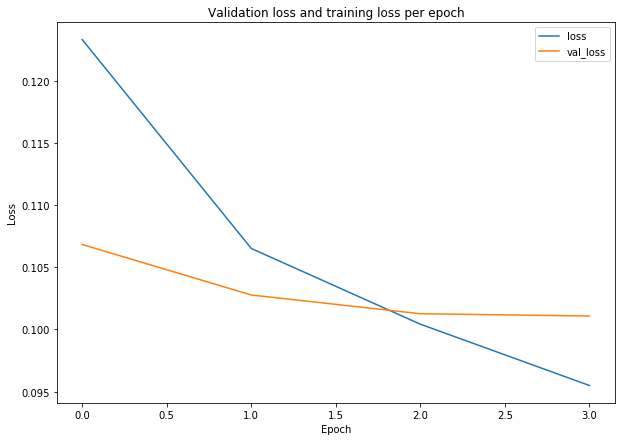

In [25]:
# plot loss per epoch
plt.figure(figsize=(10,7))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Validation loss and training loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
model.save('lstm_final.h5')

In [17]:
val_predictions = model.predict(X_test)
best_threshold = threshold_search(y_test, val_predictions, min_threshold=0.08, max_threshold=0.9)

F1 score at threshold 0.08 is 0.581513808199565
F1 score at threshold 0.09 is 0.5920414196998204
F1 score at threshold 0.1 is 0.6016050527291691
F1 score at threshold 0.11 is 0.6087419412077838
F1 score at threshold 0.12 is 0.6155586048826093
F1 score at threshold 0.13 is 0.6215465799444692
F1 score at threshold 0.14 is 0.6266743594941446
F1 score at threshold 0.15 is 0.6315889508362899
F1 score at threshold 0.16 is 0.6362423014456398
F1 score at threshold 0.17 is 0.6399517632488104
F1 score at threshold 0.18 is 0.6434716557406827
F1 score at threshold 0.19 is 0.6464507928012311
F1 score at threshold 0.2 is 0.6494522426725817
F1 score at threshold 0.21 is 0.652245401294831
F1 score at threshold 0.22 is 0.6548390450119547
F1 score at threshold 0.23 is 0.6566369511533007
F1 score at threshold 0.24 is 0.6587735598619592
F1 score at threshold 0.25 is 0.6604701045669854
F1 score at threshold 0.26 is 0.6616098679814343
F1 score at threshold 0.27 is 0.6622555184921893
F1 score at threshold 0.

In [18]:
submission_predictions = model.predict(test_data)
submission_best_predictions = (submission_predictions > best_threshold.get('threshold')).astype(int)

In [19]:
submission = pd.DataFrame({"qid":test["qid"].values})
submission['prediction'] = submission_best_predictions
submission.to_csv("submission.csv", index=False)

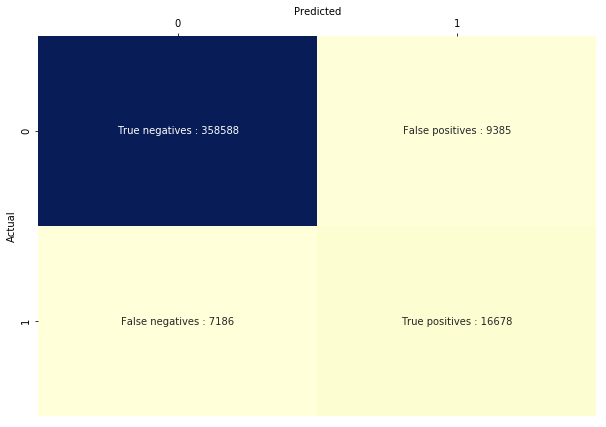

In [20]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
best_validation_predictions = (val_predictions > best_threshold.get('threshold')).astype(int)
plot_confusion_matrix(
    y_test,
    best_validation_predictions)

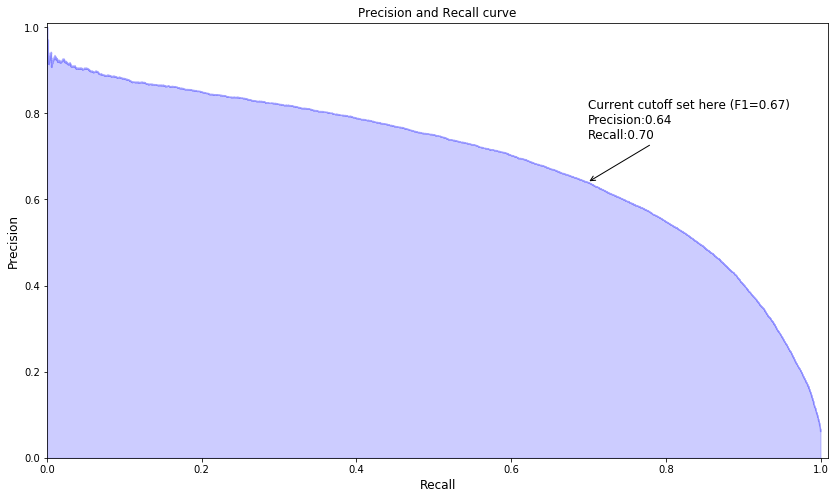

In [21]:
plot_precision_recall_curve(y_test, val_predictions, best_threshold.get('threshold'))

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(10, 7))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

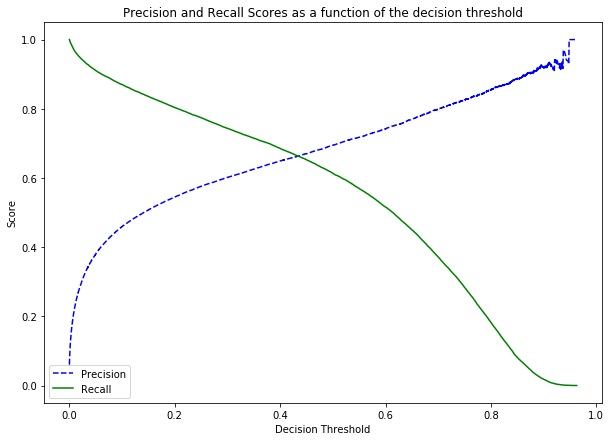

In [23]:
plot_precision_recall_vs_threshold(*precision_recall_curve(y_test, val_predictions))

In [24]:
import importlib
import capstone_utils
importlib.reload(capstone_utils)
from capstone_utils import *

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
